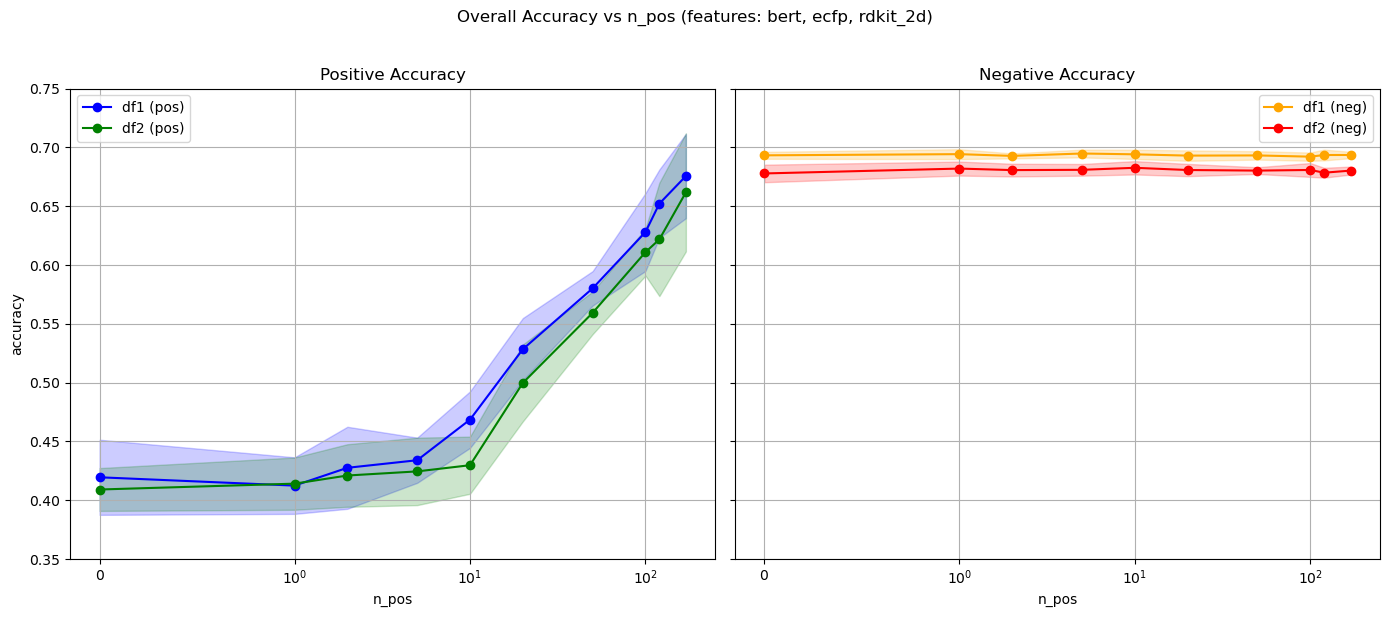

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataframe
df1 = pd.read_csv('tmp/attention_fusion/1213-1504.csv', comment='#')
df2 = pd.read_csv('tmp/attention_fusion/1213-1553.csv', comment='#')

def aggregate(df):
    return df.groupby('n_pos_req').agg(
        pos_acc_mean=('pos_acc', 'mean'),
        pos_acc_std=('pos_acc', 'std'),
        neg_acc_mean=('neg_acc', 'mean'),
        neg_acc_std=('neg_acc', 'std')
    ).reset_index()

grouped1 = aggregate(df1)
grouped2 = aggregate(df2)

# --------------------------------------------------
# Plot
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# ===== Left: pos_acc_mean =====
ax = axes[0]

ax.plot(grouped1['n_pos_req'], grouped1['pos_acc_mean'],
        marker='o', label='df1 (pos)', color='blue')
ax.fill_between(
    grouped1['n_pos_req'],
    grouped1['pos_acc_mean'] - grouped1['pos_acc_std'],
    grouped1['pos_acc_mean'] + grouped1['pos_acc_std'],
    color='blue', alpha=0.2
)

ax.plot(grouped2['n_pos_req'], grouped2['pos_acc_mean'],
        marker='o', label='df2 (pos)', color='green')
ax.fill_between(
    grouped2['n_pos_req'],
    grouped2['pos_acc_mean'] - grouped2['pos_acc_std'],
    grouped2['pos_acc_mean'] + grouped2['pos_acc_std'],
    color='green', alpha=0.2
)

ax.set_title('Positive Accuracy')
ax.set_xlabel('n_pos')
ax.set_ylabel('accuracy')
ax.set_xscale('symlog', linthresh=1)
ax.set_ylim(0.35, 0.75)
ax.grid(True)
ax.legend()

# ===== Right: neg_acc_mean =====
ax = axes[1]

ax.plot(grouped1['n_pos_req'], grouped1['neg_acc_mean'],
        marker='o', label='df1 (neg)', color='orange')
ax.fill_between(
    grouped1['n_pos_req'],
    grouped1['neg_acc_mean'] - grouped1['neg_acc_std'],
    grouped1['neg_acc_mean'] + grouped1['neg_acc_std'],
    color='orange', alpha=0.2
)

ax.plot(grouped2['n_pos_req'], grouped2['neg_acc_mean'],
        marker='o', label='df2 (neg)', color='red')
ax.fill_between(
    grouped2['n_pos_req'],
    grouped2['neg_acc_mean'] - grouped2['neg_acc_std'],
    grouped2['neg_acc_mean'] + grouped2['neg_acc_std'],
    color='red', alpha=0.2
)

ax.set_title('Negative Accuracy')
ax.set_xlabel('n_pos')
ax.set_xscale('symlog', linthresh=1)
ax.set_ylim(0.35, 0.75)
ax.grid(True)
ax.legend()

fig.suptitle(
    'Overall Accuracy vs n_pos (features: bert, ecfp, rdkit_2d)',
    y=1.02
)

plt.tight_layout()
plt.savefig('tmp/attention_fusion/png/mlp-vs-attention_fusion-scaling.png', dpi=300)
plt.show()


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

suffix = 'ecfp4096dim'  # 'ae' or 'bert'

# Load the dataframe.
df = pd.read_csv(f'tmp/attn_fusion_test1.csv')

# Group by n_train and calculate mean and std for overall_acc
grouped = df.groupby('n_pos')['overall_acc'].agg(['mean', 'std']).reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(grouped['n_train'], grouped['mean'], label='Mean Overall Accuracy', marker='o')
plt.fill_between(grouped['n_train'], 
                 grouped['mean'] - grouped['std'], 
                 grouped['mean'] + grouped['std'], 
                 alpha=0.3, label='Standard Deviation')

plt.xlabel('n_train')
plt.ylabel('overall_acc')
plt.xscale('log')
plt.ylim(0.35, 0.75)
plt.title('Overall Accuracy vs n_train with Error Bars, used features: ' + suffix)
plt.legend()
plt.grid(True)

# Save the plot
# plt.savefig(f'tmp/png/overall_scaling-{suffix}.png')

KeyError: 'n_pos'

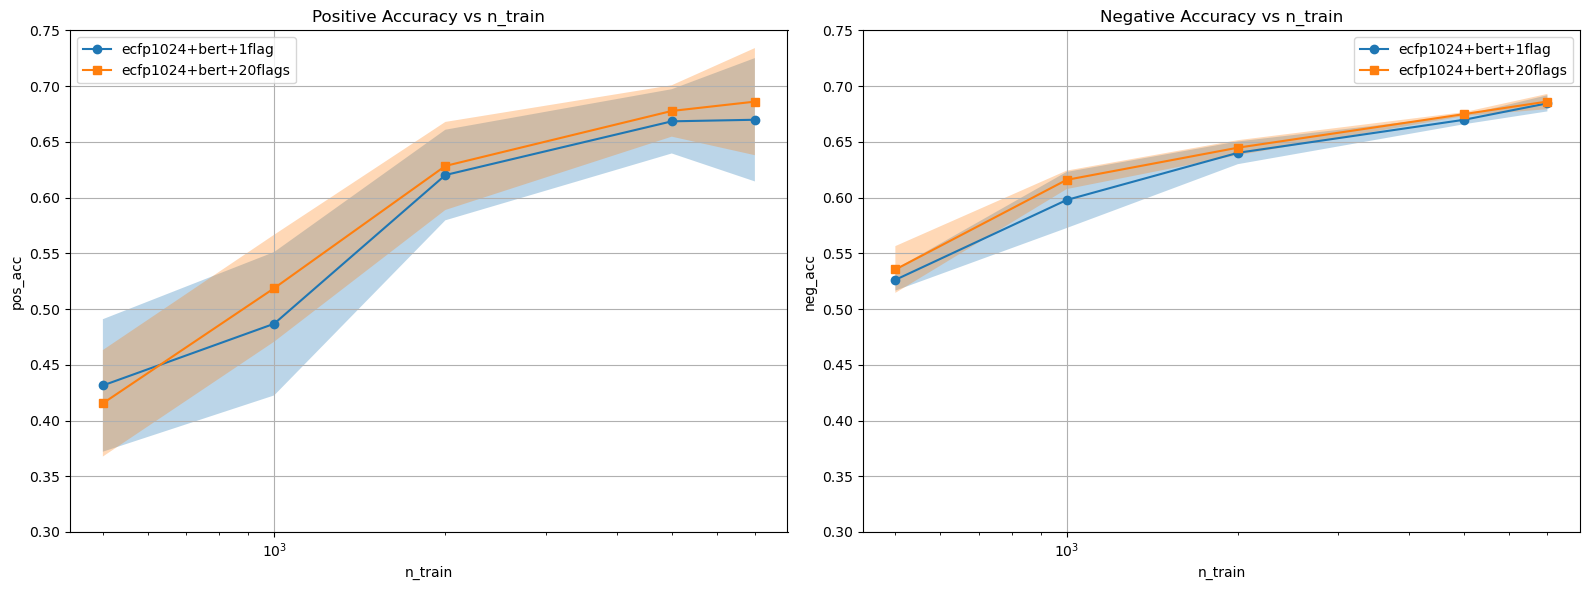

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

first_feature = 'ecfp1024+bert+1flag'
second_feature = 'ecfp1024+bert+20flags'

# Load the dataframes
df_ecfp = pd.read_csv(f'tmp/scaling/scaling-has_F-{first_feature}.csv')
df_multi = pd.read_csv(f'tmp/scaling/scaling-has_F-{second_feature}.csv')

# Aggregation function
def aggregate_data(df, metric):
    return df.groupby('n_train')[metric].agg(['mean', 'std']).reset_index()

# Prepare data for pos_acc
first_pos = aggregate_data(df_ecfp, 'pos_acc')
second_pos = aggregate_data(df_multi, 'pos_acc')

# Prepare data for neg_acc
first_neg = aggregate_data(df_ecfp, 'neg_acc')
second_neg = aggregate_data(df_multi, 'neg_acc')
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot pos_acc
ax = axes[0]
ax.plot(first_pos['n_train'], first_pos['mean'], label=first_feature, marker='o')
ax.fill_between(first_pos['n_train'], 
                first_pos['mean'] - first_pos['std'], 
                first_pos['mean'] + first_pos['std'], 
                alpha=0.3)

ax.plot(second_pos['n_train'], second_pos['mean'], label=second_feature, marker='s')
ax.fill_between(second_pos['n_train'], 
                second_pos['mean'] - second_pos['std'], 
                second_pos['mean'] + second_pos['std'], 
                alpha=0.3)

ax.set_xlabel('n_train')
ax.set_ylabel('pos_acc')
ax.set_title('Positive Accuracy vs n_train')
ax.legend()
ax.grid(True)
ax.set_ylim(0.30, 0.75)
ax.set_xscale('log')

# Plot neg_acc
ax = axes[1]
ax.plot(first_neg['n_train'], first_neg['mean'], label=first_feature, marker='o')
ax.fill_between(first_neg['n_train'], 
                first_neg['mean'] - first_neg['std'], 
                first_neg['mean'] + first_neg['std'], 
                alpha=0.3)

ax.plot(second_neg['n_train'], second_neg['mean'], label=second_feature, marker='s')
ax.fill_between(second_neg['n_train'], 
                second_neg['mean'] - second_neg['std'], 
                second_neg['mean'] + second_neg['std'], 
                alpha=0.3)

ax.set_xlabel('n_train')
ax.set_ylabel('neg_acc')
ax.set_title('Negative Accuracy vs n_train')
ax.legend()
ax.grid(True)
ax.set_ylim(0.30, 0.75)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig(f'tmp/png/comparison_scaling_{first_feature}_vs_{second_feature}.png', dpi=300)


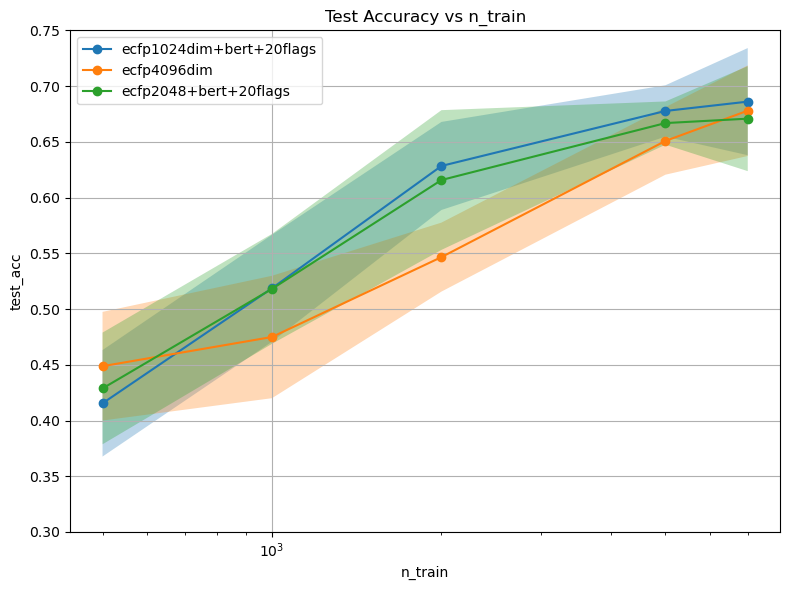

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

suf0 = 'ecfp1024dim+bert+20flags' # baseline1
suf1 = 'ecfp4096dim'   # baseline2
suf2 = 'ecfp2048+bert+20flags'
# suf3 = 'ecfp2048+bert+20flags'


sufs = [suf0, suf1, suf2]

df_0 = None
df_2 = None
df_0 = pd.read_csv(f'tmp/scaling/scaling-has_F-{suf0}.csv')
df_1 = pd.read_csv(f'tmp/scaling/scaling-has_F-{suf1}.csv')
df_2 = pd.read_csv(f'tmp/scaling/scaling-has_F-{suf2}.csv')
# df_3 = pd.read_csv(f'tmp/scaling/scaling-has_F-{suf3}.csv')


# Aggregation function
def aggregate_data(df, metric):
    return df.groupby('n_train')[metric].agg(['mean', 'std']).reset_index()

# Plotting
plt.figure(figsize=(8, 6))

for df, suf in zip([df_0, df_1, df_2], [suf0, suf1, suf2]):
    df_pos = aggregate_data(df, 'pos_acc')
    df_neg = aggregate_data(df, 'neg_acc')

    # Plot pos_acc
    plt.plot(df_pos['n_train'], df_pos['mean'], label=suf, marker='o')
    plt.fill_between(df_pos['n_train'], 
                    df_pos['mean'] - df_pos['std'], 
                    df_pos['mean'] + df_pos['std'], 
                    alpha=0.3)


plt.xlabel('n_train')
plt.ylabel('test_acc')
plt.title('Test Accuracy vs n_train')
plt.legend()
plt.grid(True)
plt.ylim(0.30, 0.75)
plt.xscale('log')

plt.tight_layout()
# plt.savefig(f'tmp/png/comparison_scaling_v0.1.png', dpi=300)


ecfp1024dim+bert+20flags = baseline1
ecfp4096dim = baseline2

入力を変えた実験のメモ
- ecfp1024+rdkit2d
    - n=500, 1000での精度はbaseline1, 2より上
    - それ以上ではecfp4096と同様
- ecfp1024+rdkit3d
    - n=5000でbaseline1と同等
    - それ以下ではecfo4096と同等かそれ以下
- ecfp1024+rdkit2d+rdkit3d
    - ガッタガタ(comparison_scaling_v0.1)

特徴量 'ecfp+rdkit2d+flag+bert' のデータがまだありません。


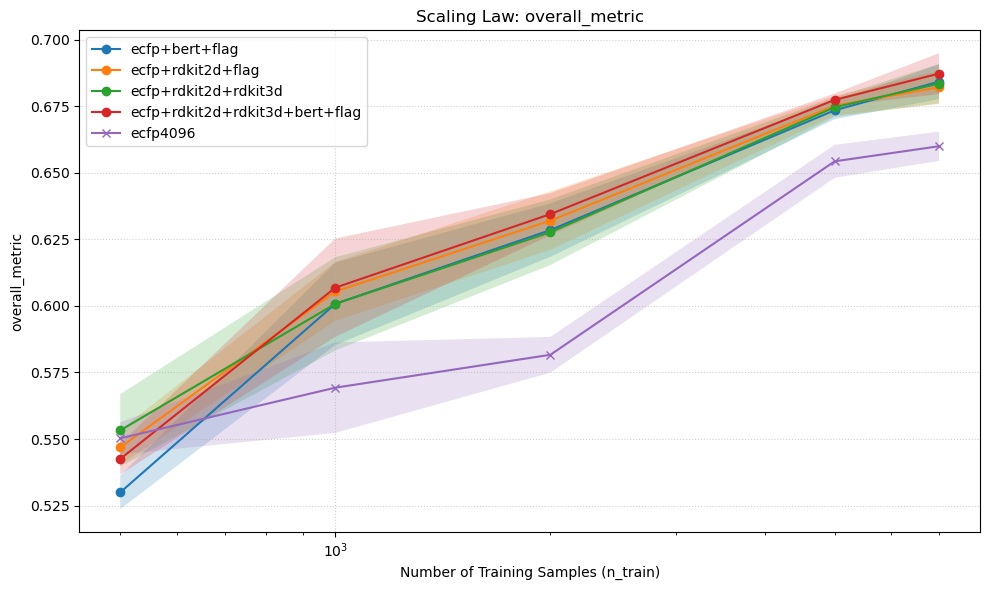

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# --- 設定 ---
CSV_PATH = "tmp/scaling/scaling_experiment_results_ALL.csv" # 出力ファイル名に合わせて変更
METRIC_COL = "overall_metric"  # "pos_metric", "val_loss" など見たい指標
LOWER_IS_BETTER = False         # LossならTrue, Accuracy/CosSimならFalse

def plot_scaling_law():
    # 1. データ読み込み
    try:
        df = pd.DataFrame(pd.read_csv(CSV_PATH))
    except FileNotFoundError:
        print("まだCSVがありません。計算が終わるまでコーヒーでも飲んで待ちましょう☕")
        return

    # 2. 注目したい組み合わせをフィルタリング (全31種は多すぎるため)
    # ここに比較したい特徴量の文字列を指定します
    # target_features = [
    #     'rdkit3d+rdkit3d',
    #     'rdkit2d+bert',
    #     'rdkit2d+flag'
    # ]
    # ALL_FEATURES = ["ecfp", "rdkit2d", "rdkit3d", "bert", "flag"]
    # target_features = []
    # for f1, f2, f3, f4, f5 in itertools.combinations(ALL_FEATURES, 5):
    #     target_features.append(f"{f1}+{f2}+{f3}+{f4}+{f5}")

    target_features = [
        "ecfp+bert+flag",        # Level 1 Baseline
        "ecfp+rdkit2d+flag",             # Level 2 Baseline
        "ecfp+rdkit2d+rdkit3d",     # +3D
        "ecfp+rdkit2d+flag+bert",        # +BERT
        "ecfp+rdkit2d+rdkit3d+bert+flag" # All
    ]
    target_features.append('ecfp4096')  # ECFP4096も比較
    plt.figure(figsize=(10, 6))
    
    for feature in target_features:
        # データフレームをフィルタリング
        plot_df = df[df["feature_type"] == feature].copy()
        if len(plot_df) == 0:
            print(f"特徴量 '{feature}' のデータがまだありません。")
            continue

        # 3. 集計 (seedごとの平均と標準偏差を算出)
        grouped = plot_df.groupby("n_train").agg({
            METRIC_COL: ["mean", "std"]
        }).reset_index()
        grouped.columns = ['n_train', 'mean', 'std']

        if feature == 'ecfp4096':
            marker_style = 'x'
        else:
            marker_style = 'o'

        # 4. プロット作成
        plt.plot(grouped["n_train"], grouped["mean"], marker=marker_style, label=feature)
        plt.fill_between(grouped["n_train"], 
                         grouped["mean"] - grouped["std"], 
                         grouped["mean"] + grouped["std"], 
                         alpha=0.2)
    # 装飾
    plt.xlabel('Number of Training Samples (n_train)')
    plt.ylabel(METRIC_COL)
    plt.title('Scaling Law: ' + METRIC_COL)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.xscale('log')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'tmp/comparison_overall.png', dpi=300)
    plt.show()
    

if __name__ == "__main__":
    plot_scaling_law()

CSVに含まれる feature_type: ['ecfp+bert+flag' 'ecfp+rdkit2d+flag' 'ecfp+rdkit2d+rdkit3d'
 'ecfp+rdkit2d+flag+bert' 'ecfp+rdkit2d+rdkit3d+bert+flag' 'ecfp']


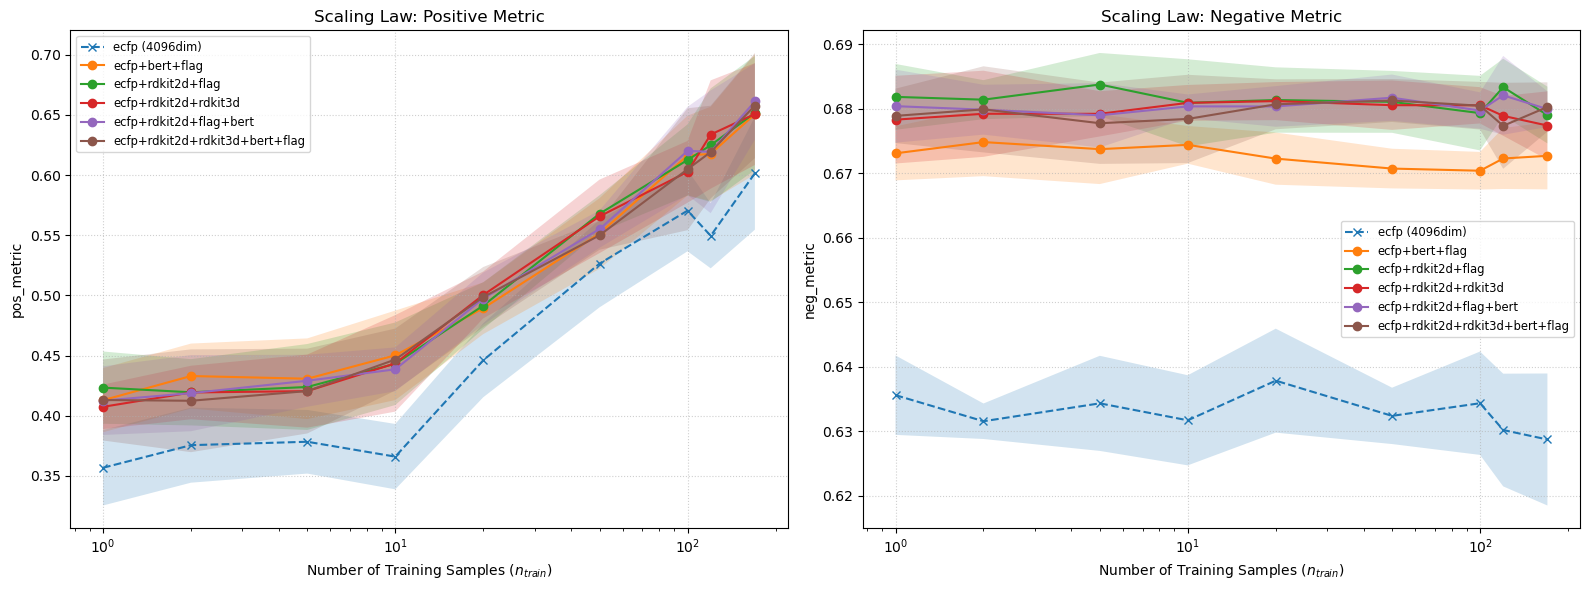

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import io

# --- 設定 ---
CSV_PATH = "tmp/attn_fusion_scaling_has-F.csv"

def plot_dual_scaling_law():
    # 1. データ読み込み
    try:
        df = pd.read_csv(CSV_PATH)
    except FileNotFoundError:
        print("CSVファイルが見つかりません。パスを確認してください。")
        return

    # ★修正点1: n_train の欠損(NaN)を 0 に置換し、整数型に変換
    if df['n_train'].isnull().any():
        print("Warning: 'n_train' に空欄が含まれています。0として扱います。")
        df['n_train'] = df['n_train'].fillna(0)
    
    df['n_train'] = df['n_train'].astype(int)

    # ★デバッグ: 実際の feature_type を確認
    existing_features = df['feature_type'].unique()
    print(f"CSVに含まれる feature_type: {existing_features}")

    # プロット対象リスト
    target_features = [
        "ecfp",
        "ecfp+bert+flag",
        "ecfp+rdkit2d+flag",
        "ecfp+rdkit2d+rdkit3d",
        "ecfp+rdkit2d+flag+bert",
        "ecfp+rdkit2d+rdkit3d+bert+flag"
    ]
    
    # リストになくてもCSVにあるものを追加するロジック（必要に応じて有効化）
    # for f in existing_features:
    #     if f not in target_features:
    #         target_features.append(f)
    
    # 'ecfp' など、リストにないものがCSVにある場合の簡易追加
    if 'ecfp' in existing_features and 'ecfp' not in target_features:
        target_features.append('ecfp')

    # 2. プロット作成
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    metrics = [
        ("pos_metric", axes[0], "Positive Metric"),
        ("neg_metric", axes[1], "Negative Metric")
    ]

    plot_count = 0  # 実際にプロットされた本数をカウント

    for metric_col, ax, title in metrics:
        for feature in target_features:
            plot_df = df[df["feature_type"] == feature].copy()
            plot_df = plot_df[plot_df['n_pos_req']>0]
            
            # データがない場合はスキップ
            if len(plot_df) == 0:
                continue

            # 3. 集計
            grouped = plot_df.groupby("n_pos_req").agg({
                metric_col: ["mean", "std"]
            }).reset_index()
            grouped.columns = ['n_pos_req', 'mean', 'std']
            
            # ★デバッグ: 集計結果が空でないか確認
            if len(grouped) == 0:
                print(f"Feature '{feature}' はデータがありますが、集計後に空になりました。")
                continue

            if feature == 'ecfp4096' or feature == 'ecfp': # ecfpも含める
                marker_style = 'x'
                linestyle = '--'
                feature = feature + " (4096dim)" 
            else:
                marker_style = 'o'
                linestyle = '-'

            ax.plot(grouped["n_pos_req"], grouped["mean"], 
                    marker=marker_style, linestyle=linestyle, label=feature)
            ax.fill_between(grouped["n_pos_req"], 
                            grouped["mean"] - grouped["std"], 
                            grouped["mean"] + grouped["std"], 
                            alpha=0.2)
            plot_count += 1
        
        ax.set_xlabel('Number of Training Samples ($n_{train}$)')
        ax.set_ylabel(metric_col)
        ax.set_title(f'Scaling Law: {title}')
        ax.grid(True, linestyle=':', alpha=0.6)
        
        # ★ここが重要: 0を含むデータの対数軸表示設定
        ax.set_xscale('log')
        
        # データが1つでもあれば凡例を表示
        if plot_count > 0:
            ax.legend(fontsize='small')

    if plot_count == 0:
        print("エラー: プロットするデータが1つも見つかりませんでした。feature_type名を確認してください。")
    else:
        plt.tight_layout()
        plt.savefig('tmp/png/pos_and_neg_scaling_law.png', dpi=300)
        plt.show()

if __name__ == "__main__":
    plot_dual_scaling_law()

Saved attention_trend_absolute_plt.png


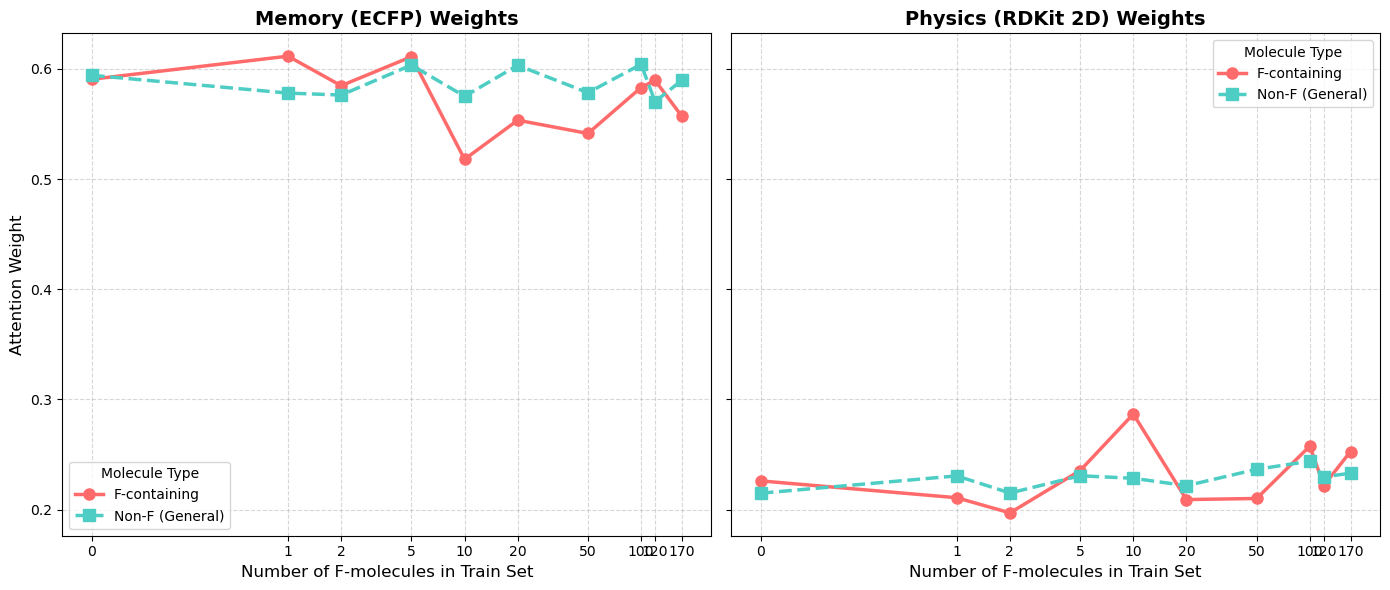

Saved attention_adaptation_diff_plt.png


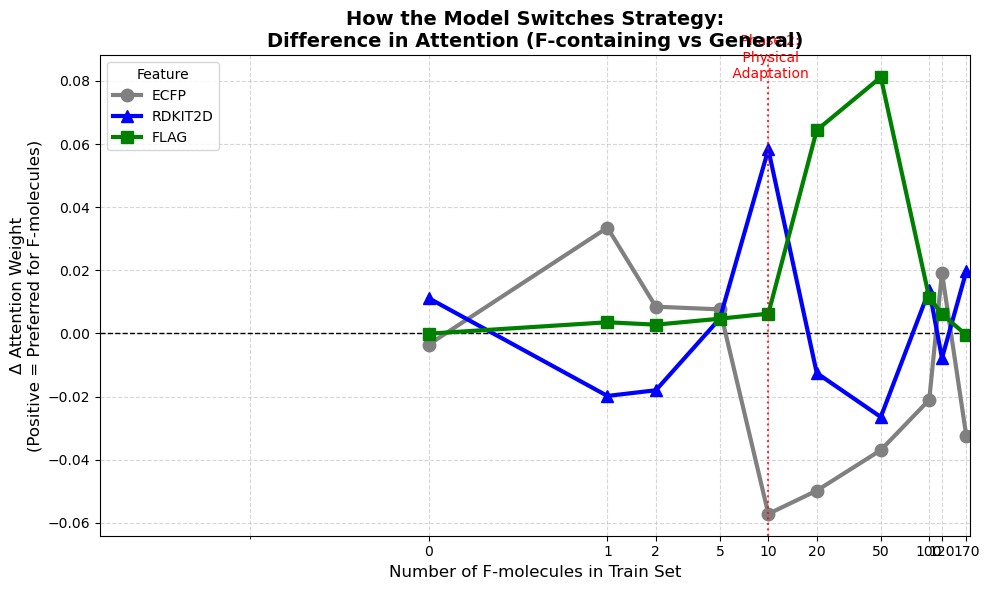

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import matplotlib.ticker as ticker

df = pd.read_csv('tmp/attn-fusion_results.csv')
df['Molecule Type'] = df['is_f_containing'].map({True: 'F-containing', False: 'Non-F (General)'})

# -----------------------------------------------------------
# Plot 1: ECFPとRDKit2Dの重み推移 (Absolute Values)
# -----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

features_to_plot = ['ecfp', 'rdkit2d']
titles = ['Memory (ECFP) Weights', 'Physics (RDKit 2D) Weights']

# 色とスタイルの設定
styles = {
    'F-containing': {'color': '#FF6B6B', 'marker': 'o', 'linestyle': '-'},
    'Non-F (General)': {'color': '#4ECDC4', 'marker': 's', 'linestyle': '--'}
}

unique_types = df['Molecule Type'].unique()

for ax, feature, title in zip(axes, features_to_plot, titles):
    # グリッド線
    ax.grid(True, which="both", ls="--", alpha=0.5)
    
    # タイプごとにループしてプロット
    for mtype in unique_types:
        subset = df[df['Molecule Type'] == mtype]
        style = styles.get(mtype, {})
        ax.plot(
            subset['num_f'], 
            subset[feature], 
            label=mtype,
            color=style.get('color'),
            marker=style.get('marker'),
            linestyle=style.get('linestyle'),
            linewidth=2.5,
            markersize=8
        )
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Number of F-molecules in Train Set', fontsize=12)
    ax.set_xscale('symlog', linthresh=1)
    
    # X軸フォーマット
    ax.set_xticks(df['num_f'].unique())
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

axes[0].set_ylabel('Attention Weight', fontsize=12)
axes[0].legend(title='Molecule Type')
axes[1].legend(title='Molecule Type')

plt.tight_layout()
plt.savefig('attention_trend_absolute_plt.png', dpi=300)
print("Saved attention_trend_absolute_plt.png")
plt.show()

# -----------------------------------------------------------
# Plot 2: 差分プロット (Difference Plot)
# -----------------------------------------------------------
# 差分計算
df_pivot = df.pivot(index='num_f', columns='Molecule Type')
diff_data = pd.DataFrame()
diff_data['num_f'] = df_pivot.index

plot_features = ['ecfp', 'rdkit2d', 'flag']
plot_labels = ['ECFP', 'RDKIT2D', 'FLAG']
plot_colors = {'ECFP': 'gray', 'RDKIT2D': 'blue', 'FLAG': 'green'}
plot_markers = {'ECFP': 'o', 'RDKIT2D': '^', 'FLAG': 's'}

plt.figure(figsize=(10, 6))
plt.grid(True, which="both", ls="--", alpha=0.5)

# ゼロライン
plt.axhline(0, color='black', linewidth=1, linestyle='--')

# 各特徴量の差分をプロット
for feat, label in zip(plot_features, plot_labels):
    # Diff = F - NonF
    diff_vals = (df_pivot[(feat, 'F-containing')] - df_pivot[(feat, 'Non-F (General)')]).values
    
    plt.plot(
        diff_data['num_f'], 
        diff_vals, 
        label=label,
        color=plot_colors[label],
        marker=plot_markers[label],
        linewidth=3,
        markersize=9
    )

# N=10 のハイライト
plt.axvline(10, color='red', linestyle=':', alpha=0.8)
plt.text(10, 0.08, ' Phase 2:\n Physical\n Adaptation', color='red', fontsize=10, ha='center', va='bottom')

plt.xscale('symlog', linthresh=1)
plt.xticks(df['num_f'].unique())
plt.gca().get_xaxis().set_major_formatter(ticker.ScalarFormatter())

plt.title('How the Model Switches Strategy:\nDifference in Attention (F-containing vs General)', fontsize=14, fontweight='bold')
plt.xlabel('Number of F-molecules in Train Set', fontsize=12)
plt.ylabel('Δ Attention Weight\n(Positive = Preferred for F-molecules)', fontsize=12)
plt.legend(title='Feature')

plt.tight_layout()
plt.savefig('attention_adaptation_diff_plt.png', dpi=300)
print("Saved attention_adaptation_diff_plt.png")
plt.show()

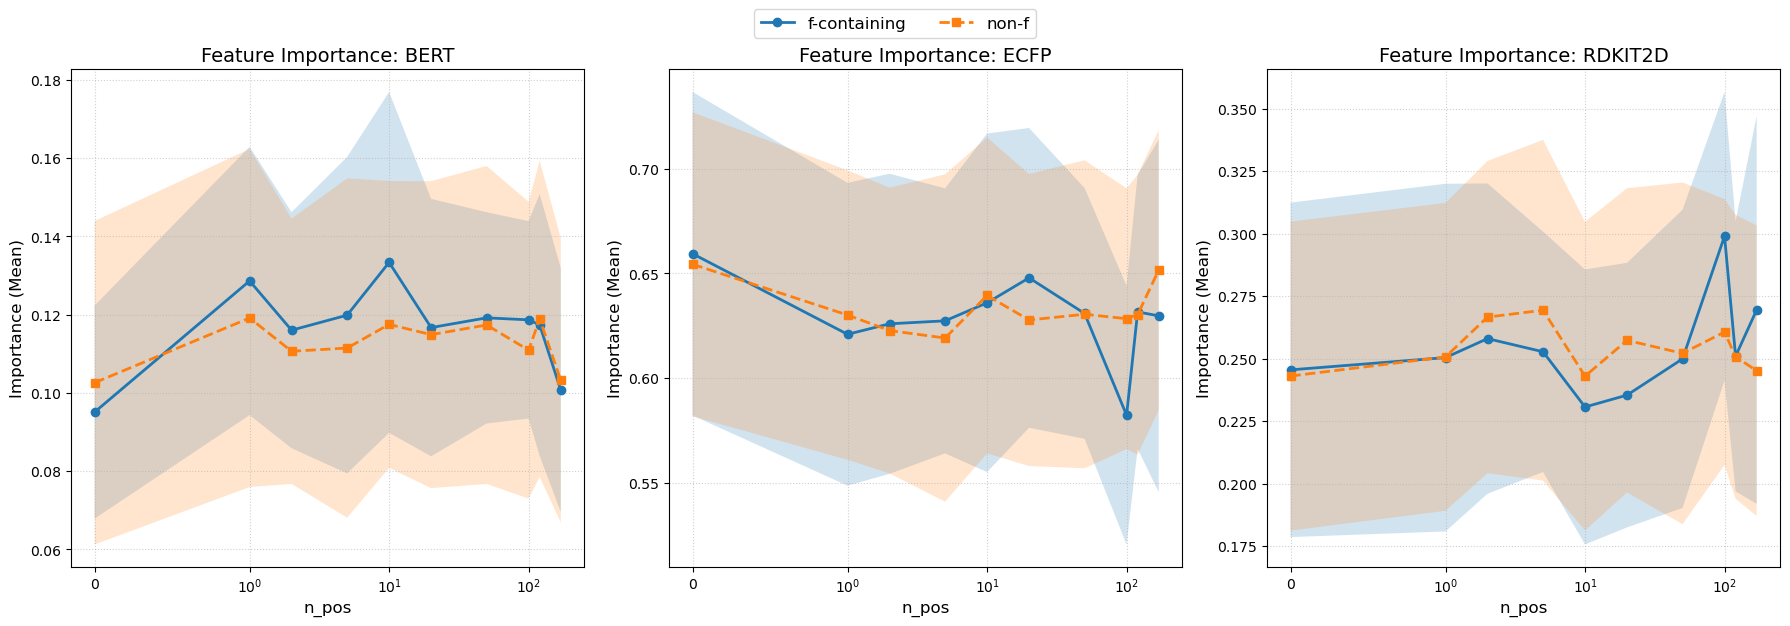

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import io


df = pd.read_csv('tmp/attention_fusion/attn_fusion_weights_3features.csv')

# グラフの設定
features = ['bert', 'ecfp', 'rdkit2d']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 色とスタイルの設定
colors = {'f-containing': '#1f77b4', 'non-f': '#ff7f0e'}
markers = {'f-containing': 'o', 'non-f': 's'}
linestyles = {'f-containing': '-', 'non-f': '--'}

for i, feat in enumerate(features):
    ax = axes[i]
    mean_col = f'{feat}_mean'
    std_col = f'{feat}_std'
    
    for split_name in ['f-containing', 'non-f']:
        subset = df[df['split'] == split_name]
        subset = subset.sort_values('n_pos')
        
        # 平均値のプロット（線）
        ax.plot(
            subset['n_pos'], 
            subset[mean_col], 
            label=split_name,
            color=colors[split_name],
            marker=markers[split_name],
            linestyle=linestyles[split_name],
            linewidth=2
        )
        
        # 標準偏差の範囲をfill_betweenで描画（帯）
        # alphaで透明度を指定し、重なりを見やすくする
        ax.fill_between(
            subset['n_pos'],
            subset[mean_col] - subset[std_col],
            subset[mean_col] + subset[std_col],
            color=colors[split_name],
            alpha=0.2, # 透明度20%
            edgecolor=None # 枠線はなしですっきりさせる
        )
    
    ax.set_title(f'Feature Importance: {feat.upper()}', fontsize=14)
    ax.set_xlabel('n_pos', fontsize=12)
    ax.set_ylabel('Importance (Mean)', fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.set_xscale('symlog', linthresh=1)
    # ax.set_ylim(0, 1)


# 凡例をグラフの上部に配置
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=12)

plt.tight_layout()
plt.savefig('tmp/attention_fusion/png/3features_importance_comparison.png', dpi=300)  
plt.show()